In [5]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-11-2022)


In [6]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/E_reco/')

from Dataset_Creation import sys_dataset
import Dataset_load

In [7]:
dataset_asimov = Dataset_load.create_asimov()

## Single Cases

In [24]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

bias = [0.1]
sigma = 0.0


datasets = []
datasets_N = []

for b in bias:

    sys = sys_dataset(dataset_asimov= dataset_asimov,
                            shift = 0, 
                            tilt = 0,
                              bias = b, 
                             sigma = sigma,
                            rnd = False,
                     e_reco_creation=10,
                     cutoff = True)
    zero = 1e-12
    penalising_invcovmatrix = np.zeros((2, 2))
    if b ==0 :
        b_ = zero
    else:
        b_ = b
    np.fill_diagonal(penalising_invcovmatrix, [1/b_**2, 1/zero**2])

    dataset = sys.create_dataset()
    dataset_N = sys.create_dataset_N(e_reco_n = 10)
    dataset_N.models.parameters['resolution'].frozen = True

    dataset_N.penalising_invcovmatrix = penalising_invcovmatrix


    for p in ['norm', 'tilt', 'sigma']:
        dataset_N.models.parameters[p].frozen = True
        dataset.models.parameters[p].frozen = True

    datasets.append(dataset)
    datasets_N.append(dataset_N)
datasets = Datasets(datasets)
datasets_N = Datasets(datasets_N)


In [25]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : RsX1RcKM
  Instrument : 
  Models     : ['Source', 'RsX1RcKM-bkg']




In [30]:
%%time
fit = Fit(store_trace=False)
minuit_opts = {"tol": 0.1, "strategy": 2}
fit.optimize_opts = minuit_opts
result = fit.run(datasets)
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 67
	total stat : -752491.10

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 797 ms, sys: 0 ns, total: 797 ms
Wall time: 813 ms


In [31]:
fit.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.525e+05                 │              Nfcn = 67               │
│ EDM = 0.000105 (Goal: 0.0002)    │            time = 0.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index     │   2.59    │   0.20    │            │            │         │         │       │
│ 1 │ par_001_amplitude │   1.06    │   0.12    │            │            │         │         │       │
│ 2 │ par_002_lambda_   │     6     │     6     │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬───────────────────────────────────────────────────────┐
│                   │     par_000_index par_001_amplitude   par_002_lambda_ │
├───────────────────┼───────────────────────────────────────────────────────┤
│     par_000_index │            0.0407         -0.000331            -0.888 │
│ par_001_amplitude │         -0.000331            0.0157             0.357 │
│   par_002_lambda_ │            -0.888             0.357              34.9 │
└───────────────────┴───────────────────────────────────────────────────────┘

In [16]:
'''%%time
fit_N = Fit(store_trace=False)
fit_N.optimize_opts = minuit_opts
result_N = fit_N.run([datasets_N[0]])
'''

'%%time\nfit_N = Fit(store_trace=False)\nfit_N.optimize_opts = minuit_opts\nresult_N = fit_N.run([datasets_N[0]])\n'

# Stat Contours

In [35]:
fit.minuit.parameters

('par_000_index', 'par_001_amplitude', 'par_002_lambda_')

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflo

E MnContours unable to find Lower y Value for x Parameter 0


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 2 has 1 dimension(s)

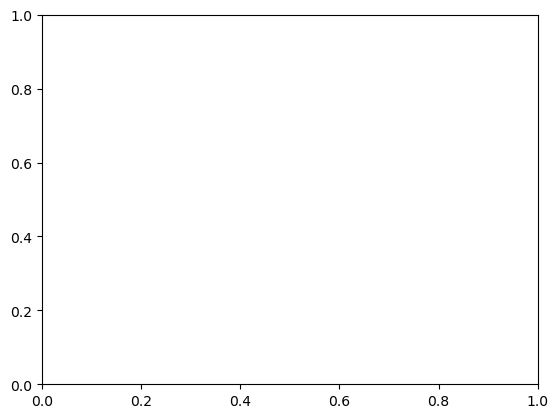

In [36]:
%%time
fit.minuit.draw_mncontour("par_000_index", "par_001_amplitude", cl=(0.68, 0.9, 0.99));

In [33]:
 contour = fit.stat_contour(
            datasets=datasets,
            x=datasets.parameters['index'],
            y=datasets.parameters['amplitude'],
            numpoints=10,
            sigma=1,
        )

x par_000_index
y par_001_amplitude
c; 0.3934693402873665
E MnContours unable to find first two points
[]
(0,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [17]:
from itertools import combinations
def make_contours(fit, datasets, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(["amplitude", "index", "norm"], r=2):
            idx1, idx2 = datasets.parameters.index(par_1), datasets.parameters.index(
                par_2
            )
            name1 = datasets.models.parameters_unique_names[idx1]
            name2 = datasets.models.parameters_unique_names[idx2]
            contour = fit.stat_contour(
                datasets=datasets,
                x=datasets.parameters[par_1],
                y=datasets.parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1}_{par_2}"] = {
                par_1: contour[name1].tolist(),
                par_2: contour[name2].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma

In [27]:
%%time
sigmas = [1, 2]
cts_sigma = make_contours(
    fit=fit,
    datasets=datasets,
    result=result,
    npoints=10,
    sigmas=sigmas,
)

x par_001_amplitude
y par_000_index
c; 0.3934693402873665
E MnContours unable to find second two points
[]
(0,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [11]:
result.success

False

In [ ]:
pars = {
    "phi": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
    "alpha": r"$\alpha$",
    "beta": r"$\beta$",
}

panels = [
    {
        "x": "alpha",
        "y": "phi",
        "cx": (lambda ct: ct["contour_alpha_amplitude"]["alpha"]),
        "cy": (lambda ct: np.array(1e11) * ct["contour_alpha_amplitude"]["amplitude"]),
    },
    {
        "x": "beta",
        "y": "phi",
        "cx": (lambda ct: ct["contour_beta_amplitude"]["beta"]),
        "cy": (lambda ct: np.array(1e11) * ct["contour_beta_amplitude"]["amplitude"]),
    },
    {
        "x": "alpha",
        "y": "beta",
        "cx": (lambda ct: ct["contour_alpha_beta"]["alpha"]),
        "cy": (lambda ct: ct["contour_alpha_beta"]["beta"]),
    },
]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ["m", "b", "c"]
for p, ax in zip(panels, axes):
    xlabel = pars[p["x"]]
    ylabel = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(
            ax,
            p["cx"](cts_sigma[ks]),
            p["cy"](cts_sigma[ks]),
            lw=2.5,
            color=colors[ks],
            label=f"{sigmas[ks]}" + r"$\sigma$",
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
plt.legend()
plt.tight_layout()

In [20]:
fit.minuit.parameters

('par_000_index',
 'par_001_amplitude',
 'par_002_sigma',
 'par_003_norm',
 'par_004_tilt')

E MnContours unable to find point on Contour 7 
 found only 6 points


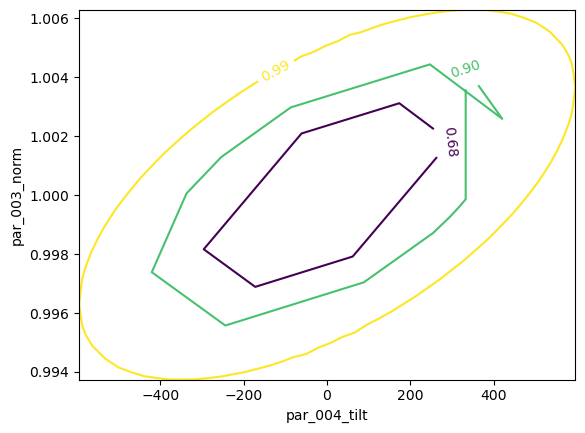

In [22]:
fit.minuit.draw_mncontour("par_004_tilt", "par_003_norm", cl=(0.68, 0.9, 0.99));